In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")
import os
import parse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
import rasterio.mask
import rasterio.features
import shapely
import shapely.geometry
import fiona
import fiona.transform

import torch
import torch.nn.functional as F

from cafo import models, utils
from cafo.data.TileDatasets import TileInferenceDataset
from cafo.data.NAIPTileIndex import NAIPTileIndex

from skimage.transform import rotate

In [2]:
device = torch.device("cuda:0")

In [3]:
index = NAIPTileIndex("../data/tmp/")

In [4]:
test_set_geoms_epsg4326 = []
test_set_geoms_epsg26918 = []
with fiona.open("../data/delmarva_testing_set_polygons.geojson", "r") as f:
    print(f.crs)
    for row in f:
        geom = row["geometry"]
        geom_transformed = utils.reverse_polygon_coordinates(
            fiona.transform.transform_geom(f.crs["init"], "epsg:4326", geom)
        )
        test_set_geoms_epsg26918.append(geom)
        test_set_geoms_epsg4326.append(geom_transformed)

{'init': 'epsg:26918'}


In [5]:
def get_url_from_geom(geom4326):
    fns = index.lookup_geom(geom4326)
    fns = [
        fn
        for fn in fns
        if "/2017/" in fn or "/2016/" in fn
    ]
    return fns[0]

def get_image_from_geom(geom4326, geom26918):
    
    url = get_url_from_geom(geom4326)
    
    shape = shapely.geometry.shape(geom26918).buffer(350).envelope
    geom_new = shapely.geometry.mapping(shape)
    with rasterio.open(url, "r") as f:
        out_image, out_transform = rasterio.mask.mask(f, [geom_new], crop=True, all_touched=True)
        _, height, width = out_image.shape
        mask = rasterio.features.rasterize([geom26918], out_shape=(height, width), transform=out_transform)
    return np.rollaxis(out_image, 0, 3), mask

def clip_to_size(img, size=362):
    
    height = img.shape[0]
    width = img.shape[1]
    
    assert height >= size
    assert width >= size
    
    y1 = (height - size) // 2
    y2 = y1
    if height % 2 == 1:
        y2 += 1
    
    x1 = (width - size) // 2
    x2 = x1
    if width % 2 == 1:
        x2 += 1
        
    return_image = img[y1:-y2, x1:-x2].copy()
    assert return_image.shape[0] == size
    assert return_image.shape[1] == size
    return return_image
        
def do_rotate(img, amount=0):
    if len(img.shape) == 3:
        img_rotated = rotate(img, amount)
    elif len(img.shape) == 2:
        img_rotated = rotate(img, amount, order=0)
    img_rotated = (img_rotated * 255.0).astype(np.uint8)
    return img_rotated

In [6]:
def get_rotated_versions(img, mask):
    imgs = []
    masks = []
    rotations = []
    for rotation in range(0,360,45):
        img_rotated = do_rotate(img.copy(), rotation)
        mask_rotated = do_rotate(mask.copy(), rotation)
    
        img_rotated_clipped = clip_to_size(img_rotated, 256)
        mask_rotated_clipped = clip_to_size(mask_rotated, 256)
        imgs.append(img_rotated_clipped)
        masks.append(mask_rotated_clipped)
        rotations.append(rotation)
    return imgs, masks, rotations

In [7]:
def measure_performance(masks, outputs):
    tps = 0
    fns = 0
    for mask, output in zip(masks, outputs):
        mask = mask == 1
        pixels = output[mask]
        num_pixels = pixels.shape[0]
        num_positive = pixels.sum()
        num_negative = num_pixels - num_positive
        tps += num_positive
        fns += num_negative
    total = tps + fns
    if total>0:
        return tps / total
    else:
        return None

In [25]:
model = models.get_unet()
state_dict = torch.load("../output/training/run2/train-all_unet_0.05_0.01/best_checkpoint.pt")
model.load_state_dict(state_dict["model_checkpoint"])
model = model.to(device)
model = model.eval()

In [17]:
model = models.get_unet()
state_dict = torch.load("../output/training/run2/train-all_unet_0.05_0.01_rotation/best_checkpoint.pt")
model.load_state_dict(state_dict["model_checkpoint"])
model = model.to(device)
model = model.eval()

In [28]:
img_idx = 0
img, mask = get_image_from_geom(test_set_geoms_epsg4326[img_idx], test_set_geoms_epsg26918[img_idx])
img_clipped = clip_to_size(img)
mask_clipped = clip_to_size(mask)

imgs, masks, rotations = get_rotated_versions(img_clipped, mask_clipped)
imgs = torch.stack([
    utils.chip_transformer(img)
    for img in imgs
]).to(device)

with torch.no_grad():
    outputs = model(imgs)
    outputs = outputs.argmax(dim=1).cpu().numpy()

imgs = np.rollaxis(imgs.cpu().numpy(), 1, 4)

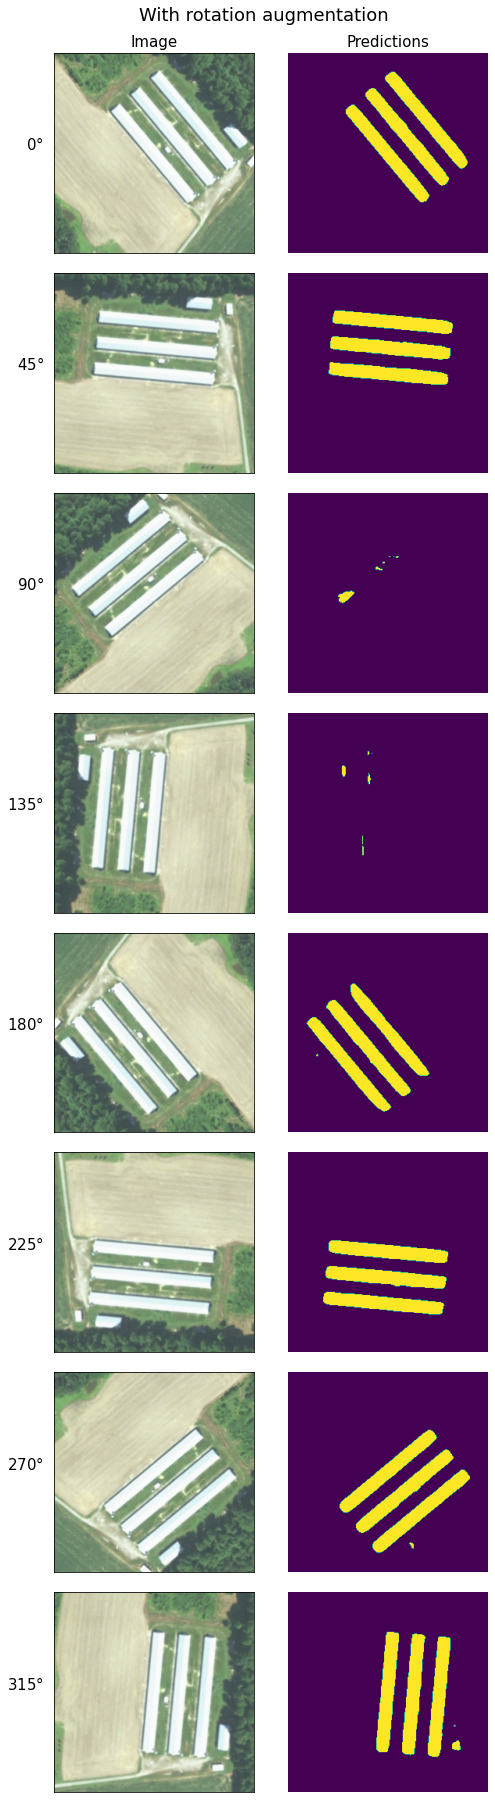

In [86]:
fig, axs = plt.subplots(len(rotations),2,figsize=(8,4*len(rotations)), facecolor="white")
for i, (img, mask, output, rotation) in enumerate(zip(imgs, masks, outputs, rotations)):
    
    axs[i, 0].imshow(img[:,:,:3])
    
    axs[i, 0].axis("on")
    axs[i, 0].set_ylabel(f"${rotation}\degree$  ", fontsize=15, rotation=0, horizontalalignment='right')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 1].imshow(output)
    if i == 0:
        axs[i, 0].set_title("Image", fontsize=15)
        axs[i, 1].set_title("Predictions", fontsize=15)
    axs[i, 1].axis("off")

plt.suptitle("With rotation augmentation",fontsize=18,y=0.9)
plt.subplots_adjust(
    wspace=0.1, 
    hspace=0.1
)
plt.show()
plt.close()

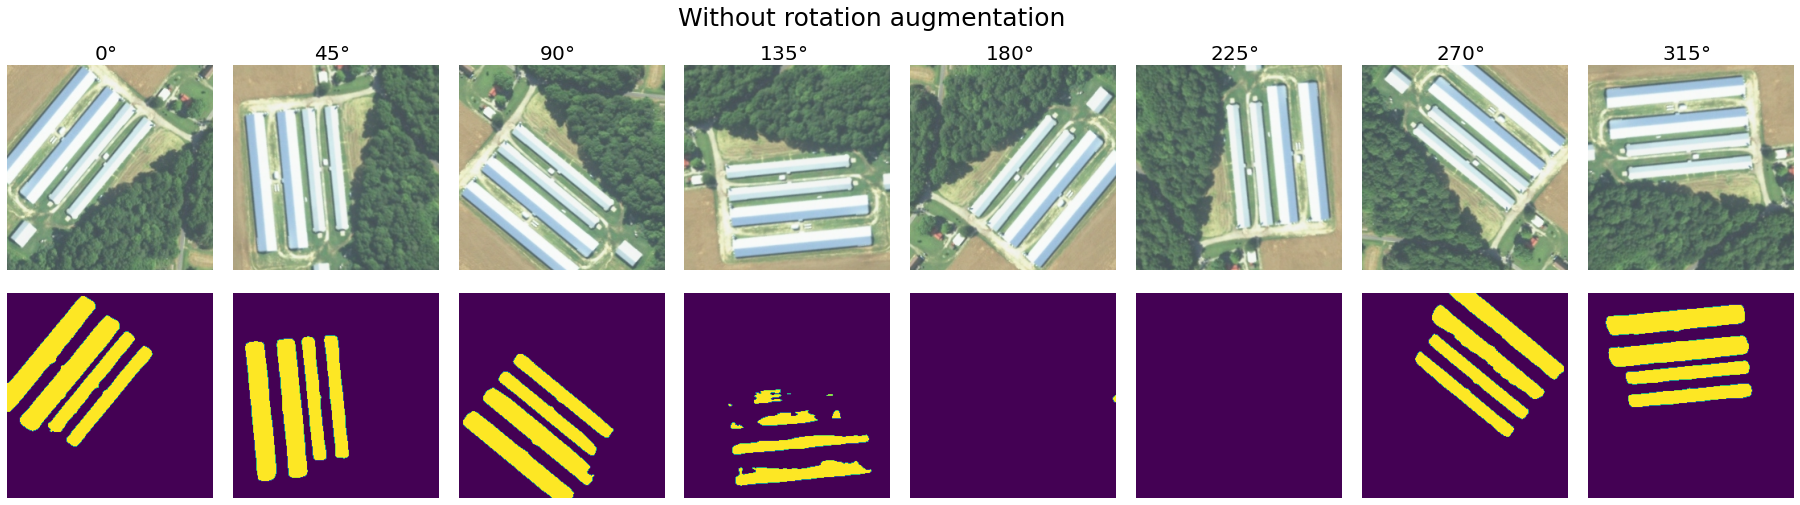

In [29]:
fig, axs = plt.subplots(2, len(rotations),figsize=(4*len(rotations),8), facecolor="white")

#axs[0,0].set_ylabel("Image", fontsize=15)
#axs[1,0].set_ylabel("Predictions", fontsize=15)

for i, (img, mask, output, rotation) in enumerate(zip(imgs, masks, outputs, rotations)):
   
    
    axs[0, i].imshow(img[:,:,:3])
    axs[1, i].imshow(output)
    
    axs[0, i].axis("off")
    axs[1, i].axis("off")    
    axs[0, i].set_title(f"${rotation}\degree$  ", fontsize=20)

plt.suptitle("Without rotation augmentation",fontsize=25)
plt.subplots_adjust(
    wspace=0.1, 
    hspace=0.1
)
plt.show()
plt.close()

## Experiment

In [9]:
def do_experiment(model):
    results = []
    for img_idx in range(0, len(test_set_geoms_epsg4326)):
        img, mask = get_image_from_geom(test_set_geoms_epsg4326[img_idx], test_set_geoms_epsg26918[img_idx])
        img_clipped = clip_to_size(img)
        mask_clipped = clip_to_size(mask)

        imgs, masks, rotations = get_rotated_versions(img_clipped, mask_clipped)
        imgs = torch.stack([
            utils.chip_transformer(img)
            for img in imgs
        ]).to(device)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = outputs.argmax(dim=1).cpu().numpy()

        result = measure_performance(masks, outputs)
        results.append(result)
    return results

In [15]:
for directory in os.listdir("../output/training/run2/"):
    print(directory, end=",")
    model = models.get_unet()
    state_dict = torch.load(f"../output/training/run2/{directory}/best_checkpoint.pt")
    model.load_state_dict(state_dict["model_checkpoint"])
    model = model.to(device)
    model = model.eval()
    
    results = do_experiment(model)

    print(np.mean(results), end=",")
    print(np.std(results))
    
    model = model.to("cpu")

train-single_unet_0.05_0.01,0.665050014738753,0.20266575480285554
train-single_unet_0.5_0.01,0.5674307572582105,0.19679034752187993
train-all_unet_0.05_0.01_rotation,0.8524354112585729,0.2701680985378997
train-all_unet_0.5_0.01_rotation,0.806760326674271,0.2799881595651347
train-all_unet_0.05_0.01,0.5866582522529785,0.2101745987140669
train-single_unet_0.1_0.01,0.716636976704521,0.22744611429886402
train-single_unet_0.1_0.01_rotation,0.8890742089579736,0.21488893905284018
train-augment_unet_0.1_0.01_rotation,0.8426309390208244,0.2705731103379071
train-augment_unet_0.5_0.01,0.5449579118093337,0.24049066211074877
train-augment_unet_0.5_0.01_rotation,0.814024867636593,0.2903337268083405
train-augment_unet_0.05_0.01_rotation,0.8594735688970419,0.26060097517727043
train-augment_unet_0.1_0.01,0.651129459539608,0.24101537696014627
train-all_unet_0.1_0.01,0.5934265970948257,0.2247033352209262
train-single_unet_0.05_0.01_rotation,0.8982764220937369,0.207785066118765
train-augment_unet_0.05_0.01